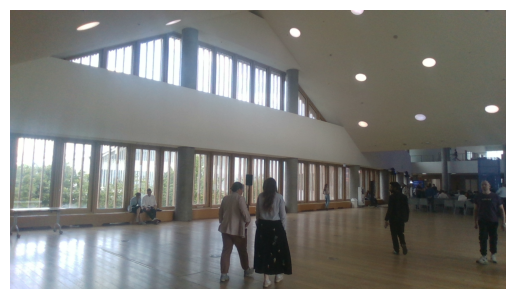

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read and display the image
img = mpimg.imread('/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb/rgb_002300.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
import cv2
import numpy as np

class PedestrianTracker:
    def __init__(self):
        self.next_id = 0

        self.tracked_pedestrians = {}  # Dictionary to store tracked pedestrians
        self.max_distance = 50  # Reduced maximum distance to consider as same person
        self.target_id = 2 # The ID we want to track
        self.last_boxes = {}  # Store last known boxes for debugging

    def get_id(self, box):
        # Get center point of the box
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        center = np.array([center_x, center_y])
        
        # Calculate box size
        box_width = x2 - x1
        box_height = y2 - y1
        box_size = box_width * box_height

        # Check if this is a new detection or matches an existing one
        best_match = None
        best_distance = float('inf')
        
        for ped_id, last_box in self.tracked_pedestrians.items():
            last_x1, last_y1, last_x2, last_y2 = last_box
            last_center_x = (last_x1 + last_x2) / 2
            last_center_y = (last_y1 + last_y2) / 2
            last_center = np.array([last_center_x, last_center_y])

            # Calculate distance between centers
            distance = np.linalg.norm(center - last_center)
            
            # Calculate size difference
            last_width = last_x2 - last_x1
            last_height = last_y2 - last_y1
            last_size = last_width * last_height
            size_ratio = min(box_size, last_size) / max(box_size, last_size)
            
            # Only consider it a match if both distance and size are similar
            if distance < self.max_distance and size_ratio > 0.7:
                if distance < best_distance:
                    best_distance = distance
                    best_match = ped_id

        if best_match is not None:
            # Update the position of existing pedestrian
            self.tracked_pedestrians[best_match] = box
            self.last_boxes[best_match] = box
            return best_match

        # If no match found, assign new ID
        new_id = self.next_id
        self.next_id += 1
        self.tracked_pedestrians[new_id] = box
        self.last_boxes[new_id] = box
        return new_id

    def is_target_pedestrian(self, ped_id):
        return ped_id == self.target_id

    def print_debug_info(self):
        print("\nDebug Information:")
        print(f"Number of tracked pedestrians: {len(self.tracked_pedestrians)}")
        for ped_id, box in self.tracked_pedestrians.items():
            x1, y1, x2, y2 = box
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            print(f"ID {ped_id}: Center at ({center_x:.1f}, {center_y:.1f}), Box size: {x2-x1:.1f}x{y2-y1:.1f}")

# Load YOLO model
model = YOLO('yolov8n.pt')  # Load the smallest YOLOv8 model

# Initialize tracker
tracker = PedestrianTracker()

# Read the image for frame 2300
frame_num = "2300"
img = cv2.imread(f'/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb/rgb_{frame_num.zfill(6)}.png')
if img is None:
    print(f"Error: Could not read image for frame {frame_num}")
    exit()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Run YOLO detection
results = model(img_rgb, classes=[0])  # class 0 is person in COCO dataset

# Draw detections on the image
for result in results:
    boxes = result.boxes
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Get confidence
        conf = float(box.conf[0].cpu().numpy())
        
        if conf > 0.3:  # Confidence threshold
            # Get pedestrian ID
            ped_id = tracker.get_id((x1, y1, x2, y2))
            
            # Only process if this is our target pedestrian (ID 1)
            if tracker.is_target_pedestrian(ped_id):
                # Draw bounding box
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # point1 = ((x1+x2)/2, y2)
                # cv2.circle(img, point1, 1, (0, 255, 0), -1)
                # Add ID and confidence label
                label = f'Target ID: {ped_id} ({conf:.2f})'
                cv2.putText(img_rgb, label, 
                           (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Print debug information
tracker.print_debug_info()

# Display the image with detections
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


0: 384x640 8 persons, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type



0: 384x640 8 persons, 2.9ms
Speed: 0.9ms preprocess, 2.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

Debug Information:
Number of tracked pedestrians: 6
ID 0: Center at (998.0, 538.0), Box size: 66.0x192.0
ID 1: Center at (584.0, 576.5), Box size: 96.0x273.0
ID 2: Center at (1235.0, 547.0), Box size: 76.0x220.0
ID 3: Center at (677.0, 567.5), Box size: 100.0x271.0
ID 4: Center at (1163.5, 500.5), Box size: 27.0x65.0
ID 5: Center at (1085.5, 484.5), Box size: 31.0x73.0


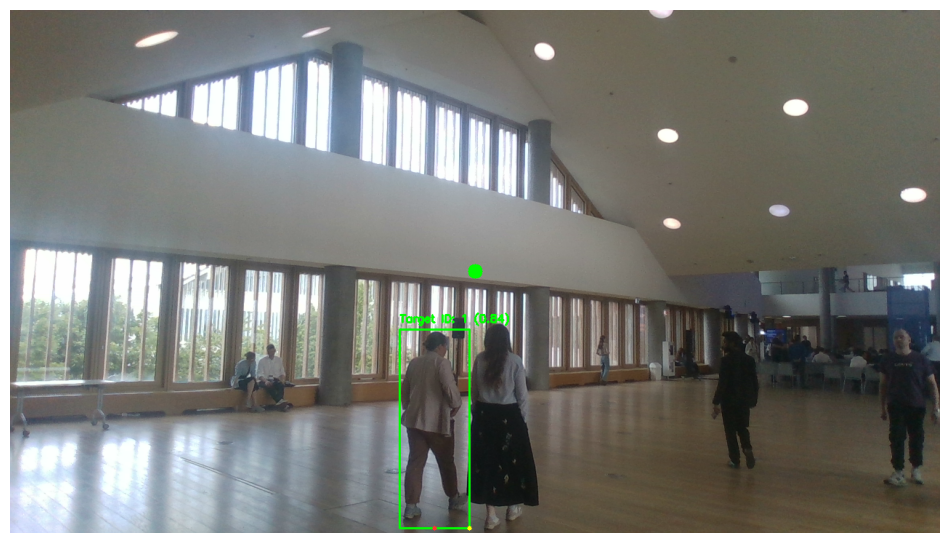

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
import cv2
import numpy as np

class PedestrianTracker:
    def __init__(self):
        self.next_id = 0
        self.tracked_pedestrians = {}  # Dictionary to store tracked pedestrians
        self.max_distance = 50  # Reduced maximum distance to consider as same person
        self.target_id = 1  # The ID we want to track
        self.last_boxes = {}  # Store last known boxes for debugging

    def get_id(self, box):
        # Get center point of the box
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        center = np.array([center_x, center_y])
        
        # Calculate box size
        box_width = x2 - x1
        box_height = y2 - y1
        box_size = box_width * box_height

        # Check if this is a new detection or matches an existing one
        best_match = None
        best_distance = float('inf')
        
        for ped_id, last_box in self.tracked_pedestrians.items():
            last_x1, last_y1, last_x2, last_y2 = last_box
            last_center_x = (last_x1 + last_x2) / 2
            last_center_y = (last_y1 + last_y2) / 2
            last_center = np.array([last_center_x, last_center_y])

            # Calculate distance between centers
            distance = np.linalg.norm(center - last_center)
            
            # Calculate size difference
            last_width = last_x2 - last_x1
            last_height = last_y2 - last_y1
            last_size = last_width * last_height
            size_ratio = min(box_size, last_size) / max(box_size, last_size)
            
            # Only consider it a match if both distance and size are similar
            if distance < self.max_distance and size_ratio > 0.7:
                if distance < best_distance:
                    best_distance = distance
                    best_match = ped_id

        if best_match is not None:
            # Update the position of existing pedestrian
            self.tracked_pedestrians[best_match] = box
            self.last_boxes[best_match] = box
            return best_match

        # If no match found, assign new ID
        new_id = self.next_id
        self.next_id += 1
        self.tracked_pedestrians[new_id] = box
        self.last_boxes[new_id] = box
        return new_id

    def is_target_pedestrian(self, ped_id):
        return ped_id == self.target_id

    def print_debug_info(self):
        print("\nDebug Information:")
        print(f"Number of tracked pedestrians: {len(self.tracked_pedestrians)}")
        for ped_id, box in self.tracked_pedestrians.items():
            x1, y1, x2, y2 = box
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            print(f"ID {ped_id}: Center at ({center_x:.1f}, {center_y:.1f}), Box size: {x2-x1:.1f}x{y2-y1:.1f}")

# Load YOLO model
model = YOLO('yolov8n.pt')  # Load the smallest YOLOv8 model

# Initialize tracker
tracker = PedestrianTracker()

# Read the image for frame 2300
frame_num = "2300"
img = cv2.imread(f'/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb/rgb_{frame_num.zfill(6)}.png')
if img is None:
    print(f"Error: Could not read image for frame {frame_num}")
    exit()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Run YOLO detection
results = model(img_rgb, classes=[0])  # class 0 is person in COCO dataset

# Draw detections on the image
for result in results:
    boxes = result.boxes
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Get confidence
        conf = float(box.conf[0].cpu().numpy())
        
        if conf > 0.3:  # Confidence threshold
            # Get pedestrian ID
            ped_id = tracker.get_id((x1, y1, x2, y2))
            
            # Only process if this is our target pedestrian (ID 1)
            if tracker.is_target_pedestrian(ped_id):
                # Draw bounding box
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Draw corner points
                point_radius = 3
                # Bottom-left corner
                # cv2.circle(img_rgb, (x1, y2), point_radius, (255, 0, 255), -1)  # Magenta
                # # Bottom-right corne
                cv2.circle(img_rgb, (x2, y2), point_radius, (255, 255, 0), -1)  # Cyan


                cv2.circle(img_rgb, (int((x1 + x2)/2), y2), point_radius, (255, 50, 50), -1)
                 
                sz = np.array(img.shape[:2]).astype(int)
                # cv2.circle(img_rgb, tuple((sz).astype(int)), 10, (0, 255, 0), -1) # Cyan

                cv2.circle(img_rgb, (640, 360), 10, (0, 255, 0), -1) # Cyan
                
                # Add ID and confidence label
                label = f'Target ID: {ped_id} ({conf:.2f})'
                cv2.putText(img_rgb, label, 
                           (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Print debug information
tracker.print_debug_info()

# Display the image with detections
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [88]:
img.shape

(720, 1280, 3)

In [86]:
(x2, y2)

(378, 550)

In [85]:
np.array(img_rgb.shape)[1::-1] / 2

array([        640,         360])

In [81]:
(int((x1 + x2)/2), y2)

(356, 550)

Loaded plane parameters: [ 0.03713292  0.7761131  -0.6294009 ]


In [ ]:
(int((x1 + x2)/2), y2)

In [70]:
sz = np.array(img.shape[1::-1])
tuple(sz/2)

(np.float64(640.0), np.float64(360.0))

In [33]:
(int((x1 + x2)/2), y2)

(356, 550)

In [34]:
sz = np.array(img.shape[1::-1])
A = np.array([[1, 0], [0, -1]])
b = 1/2 * np.array([-1, 1]) * sz
A

array([[ 1,  0],
       [ 0, -1]])

In [72]:
b = 1/2 * np.array([-1, 1]) * sz
b

array([       -640,         360])

In [90]:
bottom = np.array((584, 713))
bottom

array([584, 713])

In [92]:
px = A @ bottom + b
px

array([        -56,        -353])

In [ ]:
f = 525
H = 1.65
H * np.array()


Image dimensions: 1280x720

0: 384x640 8 persons, 2.9ms
Speed: 1.0ms preprocess, 2.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
ID 0 - Bottom center point: (998, 634)
ID 1 - Bottom center point: (584, 713)
ID 2 - Bottom center point: (1235, 657)
ID 3 - Bottom center point: (677, 703)
ID 4 - Bottom center point: (1163, 533)
ID 5 - Bottom center point: (1085, 521)


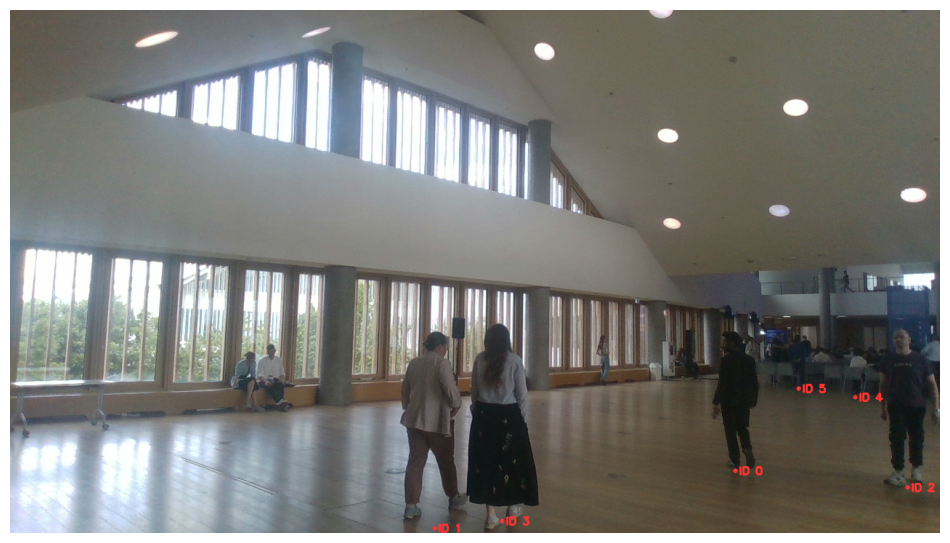

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
import cv2
import numpy as np

class PedestrianTracker:
    def __init__(self):
        self.next_id = 0
        self.tracked_pedestrians = {}  # Dictionary to store tracked pedestrians
        self.max_distance = 50  # Maximum distance to consider as same person

    def get_id(self, box):
        # Get center point of the box
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        center = np.array([center_x, center_y])
        
        # Calculate box size
        box_width = x2 - x1
        box_height = y2 - y1
        box_size = box_width * box_height

        # Check if this is a new detection or matches an existing one
        best_match = None
        best_distance = float('inf')
        
        for ped_id, last_box in self.tracked_pedestrians.items():
            last_x1, last_y1, last_x2, last_y2 = last_box
            last_center_x = (last_x1 + last_x2) / 2
            last_center_y = (last_y1 + last_y2) / 2
            last_center = np.array([last_center_x, last_center_y])

            # Calculate distance between centers
            distance = np.linalg.norm(center - last_center)
            
            # Calculate size difference
            last_width = last_x2 - last_x1
            last_height = last_y2 - last_y1
            last_size = last_width * last_height
            size_ratio = min(box_size, last_size) / max(box_size, last_size)
            
            # Only consider it a match if both distance and size are similar
            if distance < self.max_distance and size_ratio > 0.7:
                if distance < best_distance:
                    best_distance = distance
                    best_match = ped_id

        if best_match is not None:
            # Update the position of existing pedestrian
            self.tracked_pedestrians[best_match] = box
            return best_match

        # If no match found, assign new ID
        new_id = self.next_id
        self.next_id += 1
        self.tracked_pedestrians[new_id] = box
        return new_id

# Load YOLO model
model = YOLO('yolov8n.pt')  # Load the smallest YOLOv8 model

# Initialize tracker
tracker = PedestrianTracker()

# Read the image for frame 2300
frame_num = "2300"
img = cv2.imread(f'/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb/rgb_{frame_num.zfill(6)}.png')
if img is None:
    print(f"Error: Could not read image for frame {frame_num}")
    exit()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
height, width = img.shape[:2]
print(f"\nImage dimensions: {width}x{height}")

# Run YOLO detection
results = model(img_rgb, classes=[0])  # class 0 is person in COCO dataset

# Draw detections on the image
for result in results:
    boxes = result.boxes
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Get confidence
        conf = float(box.conf[0].cpu().numpy())
        
        if conf > 0.3:  # Confidence threshold
            # Get pedestrian ID
            ped_id = tracker.get_id((x1, y1, x2, y2))
            
            # Calculate bottom center point
            bottom_center_x = int((x1 + x2) / 2)
            bottom_center_y = y2
            
            # Print bottom center point coordinates
            print(f"ID {ped_id} - Bottom center point: ({bottom_center_x}, {bottom_center_y})")
            
            # Draw bottom center point
            point_radius = 3
            cv2.circle(img_rgb, (bottom_center_x, bottom_center_y), point_radius, (255, 50, 50), -1)
            
            # Add ID label
            label = f"ID {ped_id}"
            cv2.putText(img_rgb, label, 
                       (bottom_center_x + 5, bottom_center_y + 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 50, 50), 2)

# Display the image with detections
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [22]:
px = (677, 703)

In [23]:
bottom = np.array(px)

In [24]:
sz = np.array(img.shape[1::-1])
A = np.array([[1, 0], [0, -1]])
b = 1/2 * np.array([-1, 1]) * sz

In [25]:
w = A @ bottom + b
w

array([         37,        -343])

In [26]:
f = 525
H = 1.65
- H * np.array([w[0]/w[1], f/w[1], 1])

array([    0.17799,      2.5255,       -1.65])


Image dimensions: 1280x720

0: 384x640 8 persons, 2.5ms
Speed: 0.9ms preprocess, 2.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
ID 0 - Pixel coords: (998, 634)
ID 0 - World coords: (2.16, 3.16, -1.65)
ID 1 - Pixel coords: (584, 713)
ID 1 - World coords: (-0.26, 2.45, -1.65)
ID 2 - Pixel coords: (1235, 657)
ID 2 - World coords: (3.31, 2.92, -1.65)
ID 3 - Pixel coords: (677, 703)
ID 3 - World coords: (0.18, 2.53, -1.65)
ID 4 - Pixel coords: (1163, 533)
ID 4 - World coords: (4.99, 5.01, -1.65)
ID 5 - Pixel coords: (1085, 521)
ID 5 - World coords: (4.56, 5.38, -1.65)


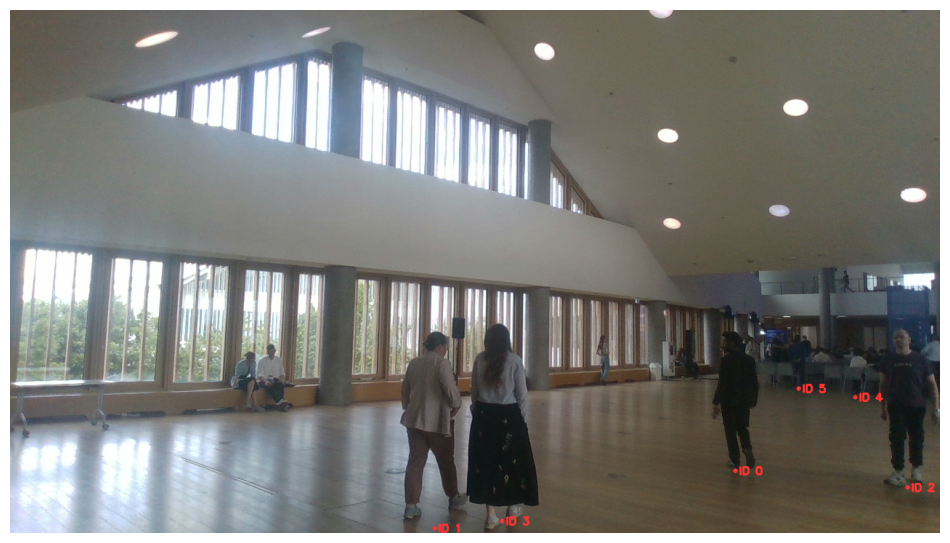

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
import cv2
import numpy as np

def pixel_to_world_coords(px, img_shape, f=525, H=1.65):
    """
    Transform pixel coordinates to world coordinates
    px: pixel coordinates (x, y)
    img_shape: (height, width) of the image
    f: focal length
    H: camera height
    """
    # Get image dimensions
    sz = np.array(img_shape[1::-1])  # width, height
    
    # Transformation matrix and vector
    A = np.array([[1, 0], [0, -1]])
    b = 1/2 * np.array([-1, 1]) * sz
    
    # Transform pixel coordinates
    w = A @ px + b
    
    # Convert to world coordinates
    world_coords = -H * np.array([w[0]/w[1], f/w[1], 1])
    
    return world_coords

class PedestrianTracker:
    def __init__(self):
        self.next_id = 0
        self.tracked_pedestrians = {}  # Dictionary to store tracked pedestrians
        self.max_distance = 50  # Maximum distance to consider as same person

    def get_id(self, box):
        # Get center point of the box
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        center = np.array([center_x, center_y])
        
        # Calculate box size
        box_width = x2 - x1
        box_height = y2 - y1
        box_size = box_width * box_height

        # Check if this is a new detection or matches an existing one
        best_match = None
        best_distance = float('inf')
        
        for ped_id, last_box in self.tracked_pedestrians.items():
            last_x1, last_y1, last_x2, last_y2 = last_box
            last_center_x = (last_x1 + last_x2) / 2
            last_center_y = (last_y1 + last_y2) / 2
            last_center = np.array([last_center_x, last_center_y])

            # Calculate distance between centers
            distance = np.linalg.norm(center - last_center)
            
            # Calculate size difference
            last_width = last_x2 - last_x1
            last_height = last_y2 - last_y1
            last_size = last_width * last_height
            size_ratio = min(box_size, last_size) / max(box_size, last_size)
            
            # Only consider it a match if both distance and size are similar
            if distance < self.max_distance and size_ratio > 0.7:
                if distance < best_distance:
                    best_distance = distance
                    best_match = ped_id

        if best_match is not None:
            # Update the position of existing pedestrian
            self.tracked_pedestrians[best_match] = box
            return best_match

        # If no match found, assign new ID
        new_id = self.next_id
        self.next_id += 1
        self.tracked_pedestrians[new_id] = box
        return new_id

# Load YOLO model
model = YOLO('yolov8n.pt')  # Load the smallest YOLOv8 model

# Initialize tracker
tracker = PedestrianTracker()

# Read the image for frame 2300
frame_num = "2300"
img = cv2.imread(f'/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb/rgb_{frame_num.zfill(6)}.png')
if img is None:
    print(f"Error: Could not read image for frame {frame_num}")
    exit()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
height, width = img.shape[:2]
print(f"\nImage dimensions: {width}x{height}")

# Run YOLO detection
results = model(img_rgb, classes=[0])  # class 0 is person in COCO dataset

# Draw detections on the image
for result in results:
    boxes = result.boxes
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Get confidence
        conf = float(box.conf[0].cpu().numpy())
        
        if conf > 0.3:  # Confidence threshold
            # Get pedestrian ID
            ped_id = tracker.get_id((x1, y1, x2, y2))
            
            # Calculate bottom center point
            bottom_center_x = int((x1 + x2) / 2)
            bottom_center_y = y2
            
            # Convert to world coordinates
            px = np.array([bottom_center_x, bottom_center_y])
            world_coords = pixel_to_world_coords(px, img.shape)
            
            # Print coordinates in both systems
            print(f"ID {ped_id} - Pixel coords: ({bottom_center_x}, {bottom_center_y})")
            print(f"ID {ped_id} - World coords: ({world_coords[0]:.2f}, {world_coords[1]:.2f}, {world_coords[2]:.2f})")
            
            # Draw bottom center point
            point_radius = 3
            cv2.circle(img_rgb, (bottom_center_x, bottom_center_y), point_radius, (255, 50, 50), -1)
            
            # Add ID label
            label = f"ID {ped_id}"
            cv2.putText(img_rgb, label, 
                       (bottom_center_x + 5, bottom_center_y + 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 50, 50), 2)

# Display the image with detections
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

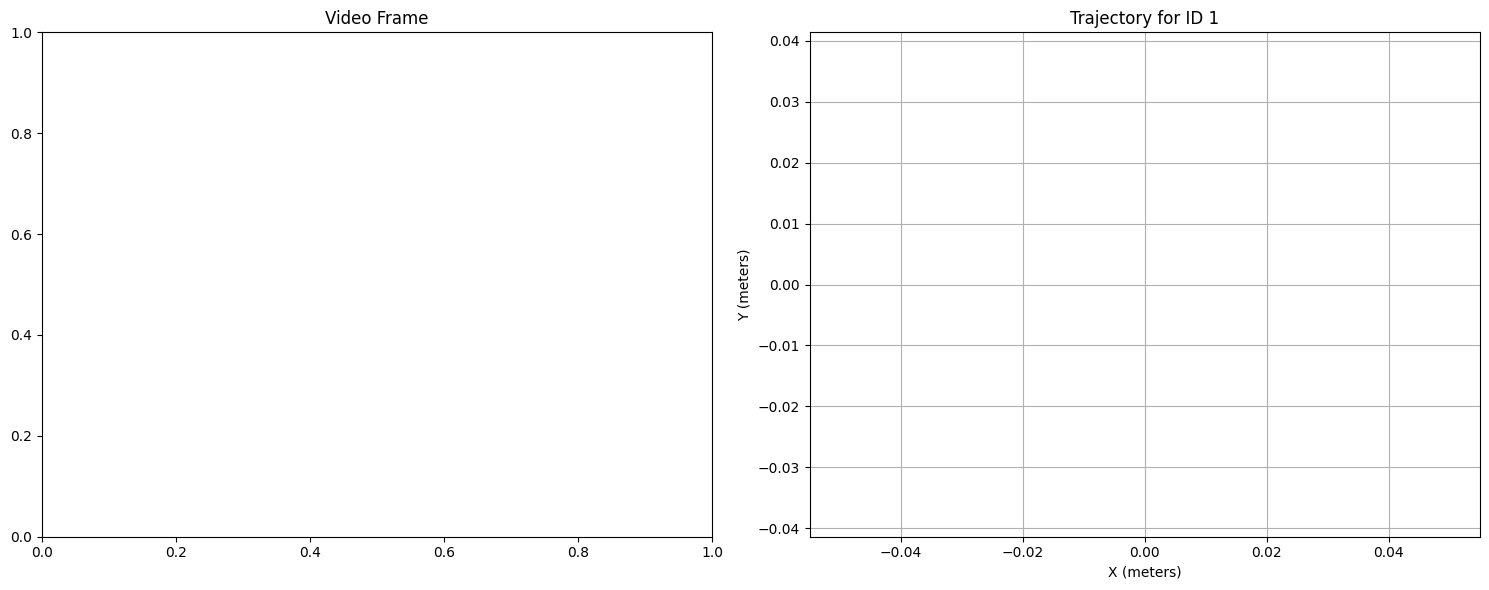

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
import cv2
import numpy as np
import os
from matplotlib.animation import FuncAnimation

def pixel_to_world_coords(px, img_shape, f=525, H=1.65):
    """
    Transform pixel coordinates to world coordinates
    px: pixel coordinates (x, y)
    img_shape: (height, width) of the image
    f: focal length
    H: camera height
    """
    # Get image dimensions
    sz = np.array(img_shape[1::-1])  # width, height
    
    # Transformation matrix and vector
    A = np.array([[1, 0], [0, -1]])
    b = 1/2 * np.array([-1, 1]) * sz
    
    # Transform pixel coordinates
    w = A @ px + b
    
    # Convert to world coordinates
    world_coords = -H * np.array([w[0]/w[1], f/w[1], 1])
    
    return world_coords

class PedestrianTracker:
    def __init__(self):
        self.next_id = 0
        self.tracked_pedestrians = {}  # Dictionary to store tracked pedestrians
        self.max_distance = 50  # Maximum distance to consider as same person
        self.trajectories = {}  # Dictionary to store trajectories
        self.frame_numbers = {}  # Dictionary to store frame numbers for each point
        self.current_frame = None
        self.fig = None
        self.ax1 = None  # For video frame
        self.ax2 = None  # For trajectory plot

    def get_id(self, box):
        # Get center point of the box
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        center = np.array([center_x, center_y])
        
        # Calculate box size
        box_width = x2 - x1
        box_height = y2 - y1
        box_size = box_width * box_height

        # Check if this is a new detection or matches an existing one
        best_match = None
        best_distance = float('inf')
        
        for ped_id, last_box in self.tracked_pedestrians.items():
            last_x1, last_y1, last_x2, last_y2 = last_box
            last_center_x = (last_x1 + last_x2) / 2
            last_center_y = (last_y1 + last_y2) / 2
            last_center = np.array([last_center_x, last_center_y])

            # Calculate distance between centers
            distance = np.linalg.norm(center - last_center)
            
            # Calculate size difference
            last_width = last_x2 - last_x1
            last_height = last_y2 - last_y1
            last_size = last_width * last_height
            size_ratio = min(box_size, last_size) / max(box_size, last_size)
            
            # Only consider it a match if both distance and size are similar
            if distance < self.max_distance and size_ratio > 0.7:
                if distance < best_distance:
                    best_distance = distance
                    best_match = ped_id

        if best_match is not None:
            # Update the position of existing pedestrian
            self.tracked_pedestrians[best_match] = box
            return best_match

        # If no match found, assign new ID
        new_id = self.next_id
        self.next_id += 1
        self.tracked_pedestrians[new_id] = box
        return new_id

    def add_to_trajectory(self, ped_id, world_coords, frame_num):
        """Add a point to the trajectory of a pedestrian"""
        if ped_id not in self.trajectories:
            self.trajectories[ped_id] = []
            self.frame_numbers[ped_id] = []
        self.trajectories[ped_id].append(world_coords)
        self.frame_numbers[ped_id].append(frame_num)

    def setup_animation(self):
        """Setup the figure and axes for animation"""
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(15, 6))
        self.ax1.set_title('Video Frame')
        self.ax2.set_title('Trajectory for ID 1')
        self.ax2.set_xlabel('X (meters)')
        self.ax2.set_ylabel('Y (meters)')
        self.ax2.grid(True)
        self.ax2.axis('equal')
        plt.tight_layout()

    def update_animation(self, frame_num):
        """Update function for animation"""
        # Clear previous frame
        self.ax1.clear()
        self.ax2.clear()
        
        # Read and process frame
        img_path = os.path.join(base_path, f'rgb_{str(frame_num).zfill(6)}.png')
        img = cv2.imread(img_path)
        if img is None:
            return
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.current_frame = img_rgb
        
        # Run YOLO detection
        results = model(img_rgb, classes=[0])
        
        # Process detections
        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                conf = float(box.conf[0].cpu().numpy())
                
                if conf > 0.3:
                    ped_id = self.get_id((x1, y1, x2, y2))
                    
                    # Calculate bottom center point
                    bottom_center_x = int((x1 + x2) / 2)
                    bottom_center_y = y2
                    
                    # Convert to world coordinates
                    px = np.array([bottom_center_x, bottom_center_y])
                    world_coords = pixel_to_world_coords(px, img.shape)
                    
                    # Add to trajectory
                    self.add_to_trajectory(ped_id, world_coords, frame_num)
                    
                    # Draw on video frame
                    if ped_id == 1:  # Only draw ID 1
                        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.circle(img_rgb, (bottom_center_x, bottom_center_y), 3, (255, 0, 0), -1)
                        cv2.putText(img_rgb, f"ID {ped_id}", (x1, y1-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Update video frame
        self.ax1.imshow(img_rgb)
        self.ax1.set_title(f'Frame {frame_num}')
        self.ax1.axis('off')
        
        # Update trajectory plot
        if 1 in self.trajectories:
            trajectory = np.array(self.trajectories[1])
            frames = self.frame_numbers[1]
            
            # Plot trajectory
            self.ax2.scatter(trajectory[:, 0], trajectory[:, 1], 
                           c=frames, cmap='viridis', alpha=0.6)
            self.ax2.plot(trajectory[:, 0], trajectory[:, 1], '--', alpha=0.3)
            
            # Set plot limits with padding
            x_min, x_max = trajectory[:, 0].min(), trajectory[:, 0].max()
            y_min, y_max = trajectory[:, 1].min(), trajectory[:, 1].max()
            x_padding = (x_max - x_min) * 0.1
            y_padding = (y_max - y_min) * 0.1
            
            self.ax2.set_xlim(x_min - x_padding, x_max + x_padding)
            self.ax2.set_ylim(y_min - y_padding, y_max + y_padding)
        
        self.ax2.set_title('Trajectory for ID 1')
        self.ax2.set_xlabel('X (meters)')
        self.ax2.set_ylabel('Y (meters)')
        self.ax2.grid(True)
        self.ax2.axis('equal')

# Load YOLO model
model = YOLO('yolov8n.pt')

# Initialize tracker
tracker = PedestrianTracker()

# Base path for images
base_path = "/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb"

# Setup animation
tracker.setup_animation()

# Create animation
start_frame = 2475
end_frame = 2495
ani = FuncAnimation(tracker.fig, tracker.update_animation, 
                   frames=range(start_frame, end_frame + 1),
                   interval=100)  # 100ms between frames

plt.show()